In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gpytorch

In [ ]:
import torch
import tqdm
import numpy as np
import pandas as pd
import gpytorch
from torch.nn import Linear
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, LinearKernel, MaternKernel, AdditiveKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL, VariationalELBO
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [ ]:
def calculate_accuracy(predicted_means, predicted_vars, test_y, alpha):
    num_tasks = predicted_means.shape[1]
    accuracies = []

    for i in range(num_tasks):
        means = predicted_means[:, i]
        vars = predicted_vars[:, i]
        test_values = test_y[:, i]

        std_devs = np.sqrt(vars)
        lower_bounds = means - alpha*std_devs
        upper_bounds = means + alpha*std_devs

        correct_predictions = (test_values >= lower_bounds) & (test_values <= upper_bounds)
        accuracy = np.mean(correct_predictions)
        accuracies.append(accuracy)

    return accuracies

#Construct a layer: initialize + forward
class DGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=256, linear_mean=True):
        #Inducing points are points in input space that act as a representative summary for the entire dataset.
        #They make GP models scalable to larger datasets (optimized during training)
        inducing_points = torch.randn(output_dims, num_inducing, input_dims)
        batch_shape = torch.Size([output_dims])
        #Choose CVD since exact inference can be computationally prohibitive
        #Approximates the true posterior distribution with a multivariate normal distribution
        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        #Defines how to propagate approximations through the model
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy, input_dims, output_dims)
        self.mean_module = ConstantMean() if linear_mean else LinearMean(input_dims)

        rbf_kernel = RBFKernel(ard_num_dims=input_dims, batch_shape=batch_shape)
        linear_kernel = LinearKernel(ard_num_dims=input_dims, batch_shape=batch_shape)
        matern_kernel = MaternKernel(nu=2.5, batch_shape=batch_shape, ard_num_dims=input_dims)
        additive_kernel = AdditiveKernel(rbf_kernel, matern_kernel)
        self.covar_module = ScaleKernel(matern_kernel, batch_shape=batch_shape, ard_num_dims = None)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [ ]:
#Construct a model: initiliaze + build architecture and forward
class MultitaskDeepGP(DeepGP):
    def __init__(self, train_x_shape,output_dims,num_tasks):
        #Initialize some stuff
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.num_layers = len(output_dims)
        #Given output_dims, which specifies the architecture of the network, we create it
        for i in range(len(output_dims)):
            if(i == 0):
                #first layer
                layer = DGPHiddenLayer(input_dims=train_x_shape[-1],output_dims=output_dims[i],linear_mean=True)
                self.layers.append(layer)
            else:
                #hidden layers
                layer = DGPHiddenLayer(input_dims=output_dims[i-1],output_dims=output_dims[i],linear_mean=True)
                self.layers.append(layer)
        #last layer
        self.last_layer = DGPHiddenLayer(input_dims=output_dims[-1],output_dims=num_tasks,linear_mean=False)
        self.likelihood = MultitaskGaussianLikelihood(num_tasks=num_tasks)


    def forward(self, inputs):
        #just propagating data through the network. go look at DGPHiddenLayer's forward function for unneceasry details
        rep = inputs
        for i, layer in enumerate(self.layers):
            rep = layer(rep)
        output = self.last_layer(rep)
        return output


    def predict(model, test_x):
        batch_size = 100
        n = test_x.size(0)
        means_list = []
        variances_list = []

        with torch.no_grad():
            for i in range(0, n, batch_size):
                batch_x = test_x[i:i + batch_size]
                preds = model.likelihood(model(batch_x)).to_data_independent_dist()
                means_list.append(preds.mean.mean(0))
                variances_list.append(preds.variance.mean(0))

        means = torch.cat(means_list)
        variances = torch.cat(variances_list)

        return means, variances

In [ ]:
class EarthquakeMagnitudePredictor:
  def __init__(self, feature_list, label_list, features_csv, output_dims):
      super().__init__()
      features_df = pd.read_csv(features_csv)
      epsilon = 1e-7
      feature_data = np.log10(np.where(np.isnan(features_df[feature_list].values) | (features_df[feature_list].values < 0), 0, features_df[feature_list].values) + epsilon)
      label_data = np.log10(np.nan_to_num(features_df[label_list].values, nan=0.0) + epsilon)

      X = feature_data
      Y = label_data
      train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.224, shuffle= False)#True, random_state=42)
      train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
      train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
      self.alpha = None
      self.label_list = label_list
      self.predicted_means = None
      self.predicted_vars = None
      self.mse_list = None
      self.r2_list = None
      self.accuracy_list = None
      self.train_x = train_x
      self.train_y = train_y
      self.test_x = test_x
      self.test_y = test_y
      self.num_tasks = train_y.shape[-1]
      self.model = MultitaskDeepGP(train_x.shape,output_dims,self.num_tasks).to(device)


  def train(self, num_epochs = 750, lr = 0.1):
      #num_tasks = self.train_y.shape[-1]
      self.model.train()
      optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
      #ELBO measures how close variational distribution is to true posterior, so training a model with variational inference => maximize ELBO
      mll = DeepApproximateMLL(VariationalELBO(self.model.likelihood, self.model, num_data=self.train_y.shape[0]))

      epochs_iter = tqdm.tqdm(range(num_epochs), desc="Epoch")
      for i in epochs_iter:
          optimizer.zero_grad()
          output = self.model(self.train_x)
          loss = -mll(output, self.train_y)
          if loss.item()<=0:
            break
          epochs_iter.set_postfix(loss=loss.item())
          loss.backward()
          optimizer.step()
      torch.cuda.empty_cache()


  def eval(self, alpha=1.5):
      self.model.eval()
      self.model.likelihood.eval()
      self.alpha = alpha
      test_x = torch.tensor(self.test_x, dtype=torch.float32).to(device)
      test_y = torch.tensor(self.test_y, dtype=torch.float32).cpu().numpy()
      #redict on the test data
      predicted_means, predicted_vars = self.model.predict(test_x)
      predicted_means = predicted_means.cpu().numpy()
      predicted_vars = predicted_vars.cpu().numpy()


      #Multitask outputs -> compute metrics for each output separatel
      mse_list = []
      r2_list = []
      for i in range(self.num_tasks):
          mse = mean_squared_error(test_y[:, i], predicted_means[:, i])
          r2 = r2_score(test_y[:, i], predicted_means[:, i])
          mse_list.append(mse)
          r2_list.append(r2)
      accuracy_list = calculate_accuracy(predicted_means, predicted_vars, test_y, alpha)
      self.predicted_means = predicted_means
      self.predicted_vars = predicted_vars
      self.mse_list = mse_list
      self.r2_list = r2_list
      self.accuracy_list = accuracy_list

      return sum(mse_list)/self.num_tasks

  def plot(self):
      label_no = self.test_y.shape[-1]
      fig, axes = plt.subplots(nrows=1, ncols=label_no, figsize=(5 * label_no, 4))

      for i in range(label_no):
          #scatter plot
          ax = axes[i] if label_no > 1 else axes
          ax.scatter(self.test_y[:, i], self.predicted_means[:, i], alpha=0.5)
          ax.set_title(f'{self.label_list[i]}')
          ax.set_xlabel('True Values')
          ax.set_ylabel('Predicted Values')
          ax.plot([self.test_y[:, i].min(), self.test_y[:, i].max()], [self.test_y[:, i].min(), self.test_y[:, i].max()], 'k--') #reference line
          textstr = f'MSE: {self.mse_list[i]:.2f}\nR²: {self.r2_list[i]:.2f}\nAccuracy within {self.alpha} std: {self.accuracy_list[i]:.2%}'
          props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
          ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                  verticalalignment='top', bbox=props)
      plt.tight_layout()
      plt.show()

In [ ]:
 #

In [ ]:
# EMP = EarthquakeMagnitudePredictor(feature_list=[' pkev12 ', ' pkev23 ', ' durP ', ' tauPd ', ' tauPt ',
#                                                   ' PDd ', ' PVd ', ' PAd ', ' PDt ', ' PVt ', ' PAt ', ' ddt_PDd ',
#                                                           ' ddt_PVd ', ' ddt_PAd '],
#                                    label_list = [' PGA ', ' PGV ', ' tPGA ', ' tPGV '],
#                                    features_csv = "/content/drive/MyDrive/Data/EEWS/EEW_features_2024-04-12.csv", output_dims=[4])
# EMP.train()
# EMP.eval()
# EMP.plot()

In [ ]:
def iterative_feature_elimination(features, target_dims, features_csv_path):
    record = []
    while len(features) > 0:
        mse_impacts = []

        #remove each feature and calculate the impact on MSE
        for feature in features:
            temp_features = [f for f in features if f != feature]
            EMP = EarthquakeMagnitudePredictor(feature_list, label_list = target_dims, features_csv=features_csv_path, output_dims=[2])
            EMP.train()
            mse = EMP.eval()
            mse_impacts.append((mse, feature))
        mse_impacts.sort()
        least_impactful_feature = mse_impacts[0][1]
        features.remove(least_impactful_feature)
        record.append((least_impactful_feature, mse_impacts[0][0]))
        print(f"Removed feature: {least_impactful_feature}, new MSE: {mse_impacts[0][0]}")

    return features, record

In [ ]:
feature_list = [' pkev12 ', ' pkev23 ', ' durP ', ' tauPd ', ' tauPt ',
        ' PDd ', ' PVd ', ' PAd ', ' PDt ', ' PVt ', ' PAt ', ' ddt_PDd ',
                ' ddt_PVd ', ' ddt_PAd ']
label_list = [' PGA ', ' PGV ', ' tPGA ', ' tPGV ']
features_csv_path = "/content/drive/MyDrive/Data/EEWS/EEW_features_2024-04-12.csv"

#feature elimination
final_features, record = iterative_feature_elimination(feature_list, label_list, features_csv_path)
print("Final selected features:", final_features)

Epoch:  13%|█▎        | 100/750 [00:07<00:50, 12.85it/s, loss=0.0695]


Removed feature:  PDt , new MSE: 0.09700332535430789


Epoch:  22%|██▏       | 162/750 [00:12<00:45, 12.83it/s, loss=0.00842]


Removed feature:  ddt_PVd , new MSE: 0.09600033843889832


Epoch:   9%|▉         | 69/750 [00:05<00:53, 12.63it/s, loss=0.00219]


Removed feature:  ddt_PDd , new MSE: 0.09795514633879066


Epoch:  11%|█▏        | 86/750 [00:06<00:51, 12.77it/s, loss=0.00582]


Removed feature:  PVd , new MSE: 0.09715061727911234


Epoch:  13%|█▎        | 97/750 [00:07<00:50, 12.91it/s, loss=0.0142]


Removed feature:  PAt , new MSE: 0.09629895351827145


Epoch:  13%|█▎        | 101/750 [00:08<00:51, 12.51it/s, loss=0.0206]


Removed feature:  pkev23 , new MSE: 0.09827920095995069


Epoch:  12%|█▏        | 90/750 [00:07<00:51, 12.75it/s, loss=0.00276]


Removed feature:  pkev12 , new MSE: 0.0960937193594873


Epoch:  16%|█▌        | 118/750 [00:09<00:49, 12.74it/s, loss=0.00108]


Removed feature:  durP , new MSE: 0.09814826538786292


Epoch:  31%|███▏      | 236/750 [00:18<00:40, 12.77it/s, loss=0.00643]


Removed feature:  ddt_PAd , new MSE: 0.10027921758592129


Epoch:  17%|█▋        | 130/750 [00:10<00:48, 12.77it/s, loss=0.00086]


Removed feature:  tauPt , new MSE: 0.10016583325341344


Epoch: 100%|██████████| 750/750 [00:58<00:00, 12.86it/s, loss=0.197]


Removed feature:  PAd , new MSE: 0.12327582482248545


Epoch: 100%|██████████| 750/750 [00:58<00:00, 12.92it/s, loss=0.278]


Removed feature:  tauPd , new MSE: 0.1225124797783792


Epoch: 100%|██████████| 750/750 [00:58<00:00, 12.91it/s, loss=0.615]


Removed feature:  PVt , new MSE: 0.1525368196889758


Epoch: 100%|██████████| 750/750 [00:57<00:00, 13.04it/s, loss=1.89]


Removed feature:  PDd , new MSE: 0.21993363462388515
Final selected features: []


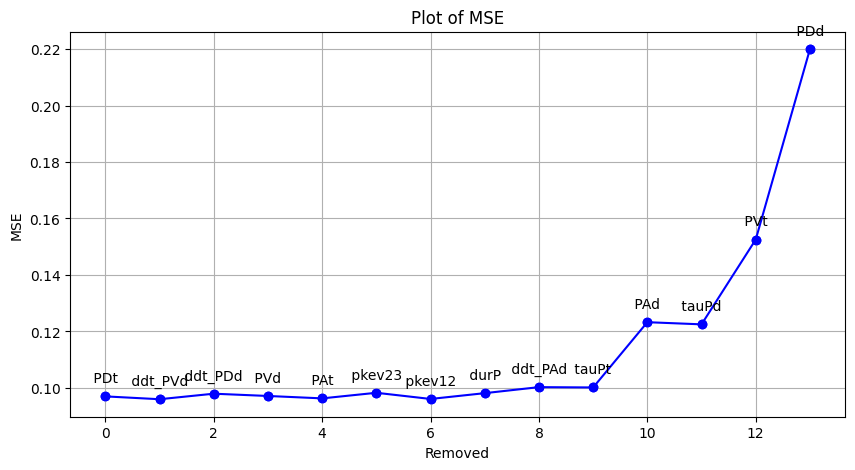

In [ ]:
labels, values = zip(*record)
plt.figure(figsize=(10, 5))
plt.plot(values, 'bo-')  # 'bo-' means blue color, circle markers, solid lines
plt.scatter(range(len(values)), values, color='b')  # Plot points

for i, (label, value) in enumerate(record):
    plt.annotate(label, (i, value), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Plot of MSE')
plt.xlabel('Removed')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

In [ ]:
selected_features = [' PAd ',' tauPd ', ' PVt ', ' PDd ']

Epoch: 100%|██████████| 3000/3000 [04:07<00:00, 12.12it/s, loss=0.118]


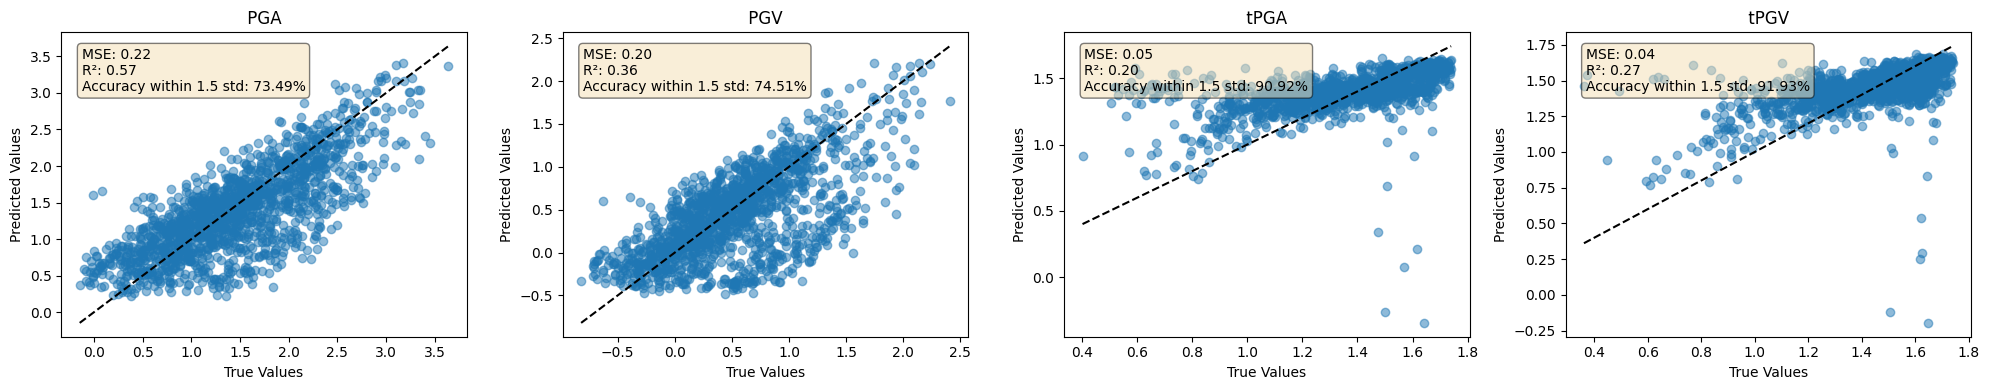

In [ ]:
EMP = EarthquakeMagnitudePredictor(selected_features, label_list = [' PGA ', ' PGV ', ' tPGA ', ' tPGV '], features_csv = "/content/drive/MyDrive/Data/EEWS/EEW_features_2024-04-12.csv", output_dims=[4])
EMP.train(num_epochs = 3000)
EMP.eval()
EMP.plot()